# Modelos_NaiveBayes_LDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import sys


In [2]:
current_dir = os.getcwd() # Obtener la ruta del directorio actual del notebook
ROOT_PATH = os.path.dirname(current_dir) # Obtener la ruta del directorio superior
sys.path.insert(1, ROOT_PATH) # Insertar la ruta en sys.path

import root # Importar el módulo root

## Preparando el dataset de entrenamiento

In [3]:
file_path = root.DIR_DATA_STAGE + 'test.csv'

In [4]:
train = pd.read_csv(file_path)
train.head()

,PLAZO,CAPITAL,DÍAS MORA,INGRESOS MENSUALES,GASTOS MENSUALES,NUM.CREDITOS SOLICITADOS,latitud,longitud,meses_transcurridos,mes_de_pago,TIPO EMPLEO_independiente,TIPO DE VIVIENDA_propia,ESTADO CIVIL_soltero/a,ESTADO CIVIL_union libre,NIVEL EDUCATIVO_postgrado,NIVEL EDUCATIVO_profesional,NIVEL EDUCATIVO_secundaria,NIVEL EDUCATIVO_tecnico,Cuotas en mora
0,30.0,0.250,1349.0,2.500,1.00,1.0,4.60971,-74.08175,31.077530,8,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
1,30.0,0.250,774.0,1.899,0.80,1.0,6.25184,-75.56359,27.365309,7,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0
2,30.0,0.350,519.0,3.000,0.80,1.0,4.14200,-73.62664,31.077530,11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,30.0,0.105,625.0,0.937,0.30,2.0,6.25184,-75.56359,61.103811,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,30.0,0.150,1719.0,1.000,0.45,1.0,4.81333,-75.69611,12.746386,8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


## Modelos para CredInfo

In [110]:
df_CredInfoT['PRÓXIMA FECHA PAGO'] = pd.to_datetime(df_CredInfoT['PRÓXIMA FECHA PAGO'])
df_CredInfoT['mes'] = df_CredInfoT['PRÓXIMA FECHA PAGO'].dt.month

In [111]:
##df_CredInfoT['Estado'] = np.where((df_CredInfoT['DÍAS MORA'] > 3) & (df_CredInfoT['Cuotas en mora'] == 1), 1, 0)
df_CredInfoT['Estado'] = (df_CredInfoT['DÍAS MORA'] > 3).astype(int)


In [112]:
df_CredInfoT = df_CredInfoT.drop(columns=['Cuotas en mora', 'PRÓXIMA FECHA PAGO', 'DÍAS MORA'])

df_CredInfoT.head()

,PLAZO,CAPITAL,INT CORRIENTE,NUM.CREDITOS SOLICITADOS,mes,Estado
0,30,250000,4692.500000,1,3,1
1,29,250000,4536.083333,1,3,1
2,30,250000,4692.500000,1,3,1
3,29,250000,4536.083333,1,3,1
4,29,250000,4536.083333,1,3,1


In [113]:
df_CredInfoT.shape

(108039, 6)

In [114]:
# Mezclar el DataFrame
df_CredInfo_shuffled = df_CredInfoT.sample(frac=1, random_state=42).reset_index(drop=True)

# Calcular el tamaño de cada subconjunto
n = len(df_CredInfoT)
size_60 = int(0.6 * n)
size_20 = int(0.2 * n)

# Dividir el DataFrame en tres subconjuntos
df_CredInfo_Train = df_CredInfo_shuffled.iloc[:size_60]
df_CredInfo_Validation = df_CredInfo_shuffled.iloc[size_60:size_60 + size_20]
df_CredInfo_Test = df_CredInfo_shuffled.iloc[size_60 + size_20:]

In [115]:
df_CredInfo_Train.Estado.value_counts()

Estado
0    42215
1    22608
Name: count, dtype: int64

### Balanceando el dataset

In [127]:
from sklearn.utils import resample

df_estado_0 = df_CredInfo_Train[df_CredInfo_Train['Estado'] == 0]
df_estado_1 = df_CredInfo_Train[df_CredInfo_Train['Estado'] == 1]
count_class_0, count_class_1 = df_CredInfo_Train['Estado'].value_counts()

# Muestra cuántos registros hay en cada clase antes del undersampling
print("Antes del overdersampling:")
print("Clase 0:", count_class_0)
print("Clase 1:", count_class_1)

Antes del overdersampling:
Clase 0: 42215
Clase 1: 22608


In [117]:
# Realiza el oversampling de la clase con menos registros (clase 1)
df_CredInfo_1over = resample(df_estado_1, 
                                         replace=True,    # Muestreo con reemplazo
                                         n_samples=count_class_0,    # Igualar al número de registros de la clase 0
                                         random_state=42)  # Fijar la semilla aleatoria para reproducibilidad

# Concatena los DataFrames de ambas clases después del oversampling
df_CredInfo_TrainB = pd.concat([df_estado_0, df_CredInfo_1over])

# Muestra cuántos registros hay en cada clase después del oversampling
print("\nDespués del oversampling:")
print(df_CredInfo_TrainB['Estado'].value_counts())

# Ahora df_balanced contiene una muestra equilibrada de ambas clases


Después del oversampling:
Estado
0    42215
1    42215
Name: count, dtype: int64


In [118]:
df_CredInfo_TrainB.shape

(84430, 6)

## Modelación

In [119]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [120]:
df_CredInfo_TrainB.columns


Index(['PLAZO', 'CAPITAL', 'INT CORRIENTE', 'NUM.CREDITOS SOLICITADOS', 'mes',
       'Estado'],
      dtype='object')

In [121]:
df_CredInfo_TrainB.head()

,PLAZO,CAPITAL,INT CORRIENTE,NUM.CREDITOS SOLICITADOS,mes,Estado
0,30,500000,9385.0,16,12,0
2,30,200000,3754.0,21,7,0
3,30,500000,9385.0,8,7,0
4,30,250000,4692.5,2,11,0
5,30,250000,4692.5,7,7,0


### Naive Bayes

In [122]:
##Función pára curva lift

def plot_lift_curve(y_true, y_proba, ax):
    # Create a dataframe with true labels and predicted probabilities
    df = pd.DataFrame({'y_true': y_true, 'y_proba': y_proba})
    df = df.sort_values('y_proba', ascending=False).reset_index(drop=True)
    
    # Calculate the cumulative gain for the lift curve
    df['cumulative_data_fraction'] = (np.arange(len(df)) + 1) / len(df)
    df['cumulative_positive_fraction'] = np.cumsum(df['y_true']) / df['y_true'].sum()
    
    # Plot the lift curve
    ax.plot(df['cumulative_data_fraction'], df['cumulative_positive_fraction'], label='Lift Curve')
    ax.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Baseline')
    ax.set_title('Lift Curve')
    ax.set_xlabel('Cumulative Data Fraction')
    ax.set_ylabel('Cumulative Positive Fraction')
    ax.legend()

In [139]:
def M_Naive_bayesTrain(X,y):
     
    model = MultinomialNB()
    model.fit(X, y)
    return model

In [151]:
def M_Naive_bayes(X, y, model):
   
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] 
   
    print("Accuracy: ", accuracy_score(y, y_pred))
    print('------------------------------')
    print(classification_report(y, y_pred))

    P_train_nb = model.predict(X)
    P_test_nb = model.predict(X)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    disp = ConfusionMatrixDisplay.from_estimator(model, X, y, normalize='true', xticks_rotation='vertical', ax=axs[0])
    axs[0].set_title('Train Data')

    disp = ConfusionMatrixDisplay.from_estimator(model, X, y, normalize='true', xticks_rotation='vertical', ax=axs[1])
    axs[1].set_title('Test Data')

    plot_lift_curve(y, y_proba, ax=axs[2])

    fig.subplots_adjust(wspace=0.3)
    plt.tight_layout()
    plt.show()
    
    X['Estado'] = y
    X['Estado_Estimado'] = y_pred
    X['Probabilidad'] = np.round(y_proba * 100,2)
    
    return X

In [142]:
Modelo1 = M_Naive_bayesTrain(X = df_CredInfo_TrainB[['PLAZO', 'CAPITAL', 'INT CORRIENTE', 'NUM.CREDITOS SOLICITADOS', 'mes']],y =df_CredInfo_TrainB['Estado'])

Accuracy:  0.7084548104956269
------------------------------
              precision    recall  f1-score   support

           0       0.89      0.63      0.74     13958
           1       0.56      0.86      0.68      7651

    accuracy                           0.71     21609
   macro avg       0.72      0.74      0.71     21609
weighted avg       0.77      0.71      0.71     21609



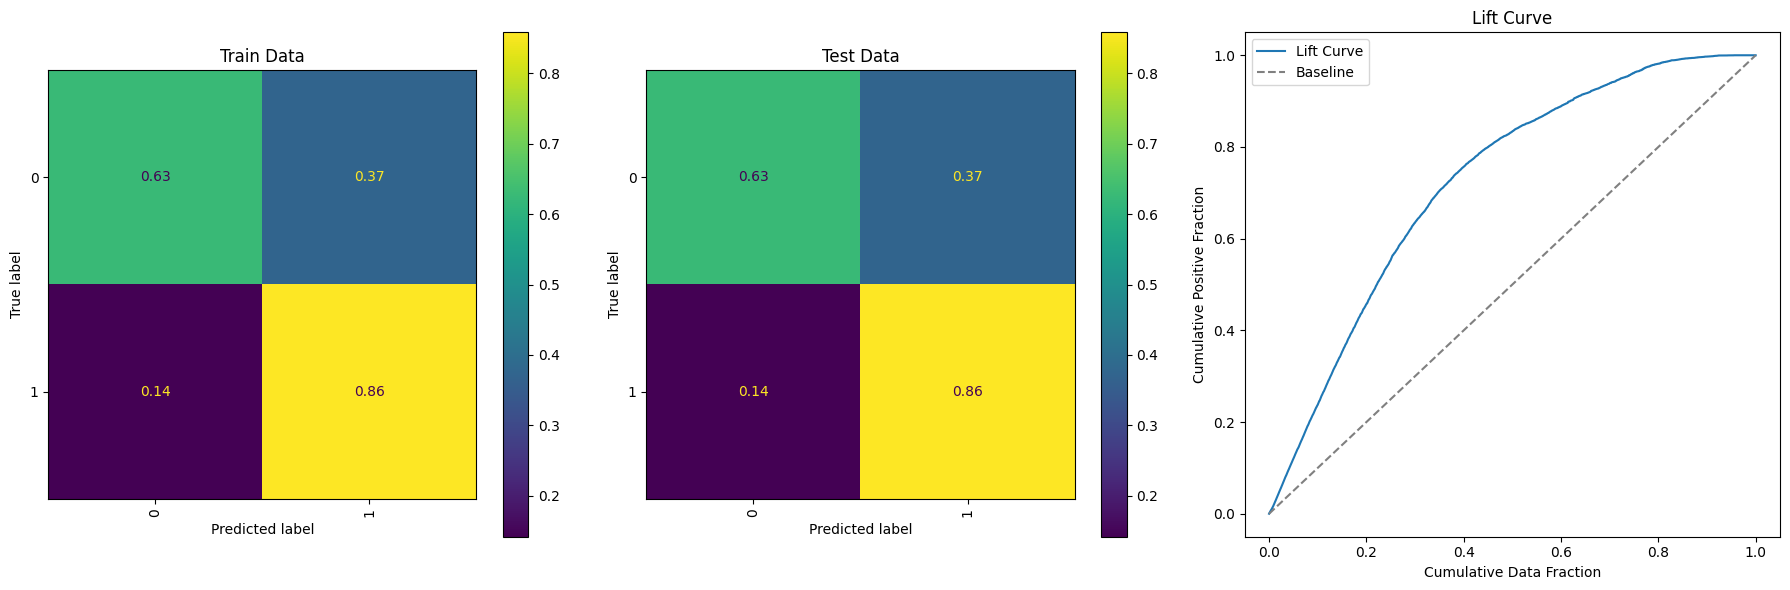

In [152]:
df_final = M_Naive_bayes (X = df_CredInfo_Test[['PLAZO', 'CAPITAL', 'INT CORRIENTE', 'NUM.CREDITOS SOLICITADOS', 'mes']],y =df_CredInfo_Test['Estado'], model = Modelo1)

In [153]:
df_final.head()

,PLAZO,CAPITAL,INT CORRIENTE,NUM.CREDITOS SOLICITADOS,mes,Estado,Estado_Estimado,Probabilidad
86430,30,350000,6569.5,7,3,0,0,37.17
86431,30,370000,6944.9,1,8,1,1,99.97
86432,30,500000,9385.0,10,2,0,0,5.38
86433,30,500000,11800.0,10,3,0,0,0.00
86434,30,350000,6569.5,6,1,0,1,60.20


### LDA

In [154]:
def M_LDATrain(X,y):
     
    model = LinearDiscriminantAnalysis()
    model.fit(X, y)
    return model

In [155]:
def M_LDA(X, y, model):
    
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] 

    print("Accuracy: ", accuracy_score(y, y_pred))
    print('------------------------------')
    print(classification_report(y, y_pred))

    P_train_lda = model.predict(X)
    P_test_lda = model.predict(X)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    disp = ConfusionMatrixDisplay.from_estimator(model, X, y, normalize='true', xticks_rotation='vertical', ax=axs[0])
    axs[0].set_title('Train Data')

    disp = ConfusionMatrixDisplay.from_estimator(model, X, y, normalize='true', xticks_rotation='vertical', ax=axs[1])
    axs[1].set_title('Test Data')

    plot_lift_curve(y, y_proba, ax=axs[2])

    fig.subplots_adjust(wspace=0.3)
    plt.tight_layout()
    plt.show()
    
    X['Estado'] = y
    X['Estado_Estimado'] = y_pred
    X['Probabilidad'] = np.round(y_proba * 100,2)
    
    return X



In [156]:
Modelo2 = M_LDATrain(X = df_CredInfo_TrainB[['PLAZO', 'CAPITAL', 'INT CORRIENTE', 'NUM.CREDITOS SOLICITADOS', 'mes']],y =df_CredInfo_TrainB['Estado'])

Accuracy:  0.6887870794576334
------------------------------
              precision    recall  f1-score   support

           0       0.92      0.57      0.70     13958
           1       0.54      0.91      0.67      7651

    accuracy                           0.69     21609
   macro avg       0.73      0.74      0.69     21609
weighted avg       0.78      0.69      0.69     21609



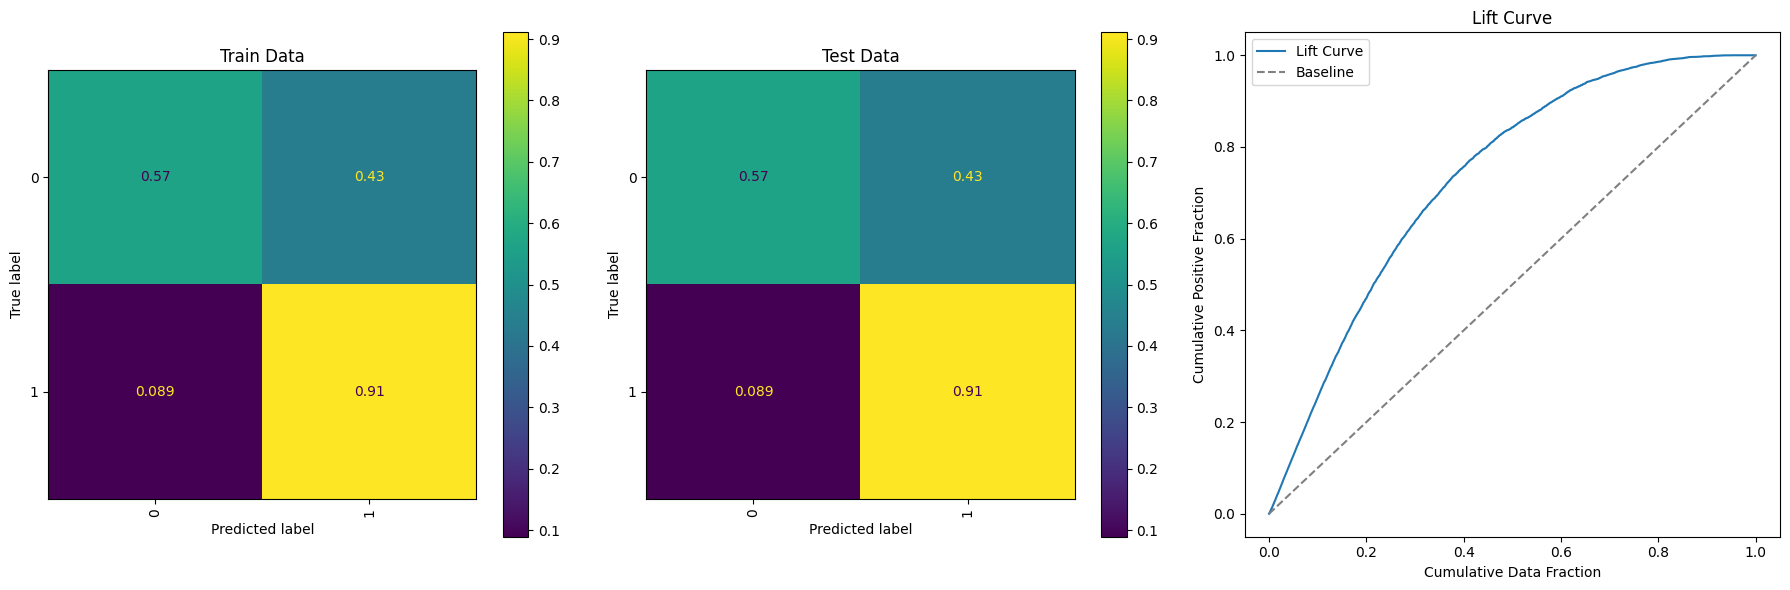

In [157]:
df_final2 = M_LDA (X = df_CredInfo_Test[['PLAZO', 'CAPITAL', 'INT CORRIENTE', 'NUM.CREDITOS SOLICITADOS', 'mes']],y =df_CredInfo_Test['Estado'], model = Modelo2)